## Part 2 -- 市值滚动策略的参数回测

为了研究不同市值股票在不同牛熊市周期的表现，以流动市值的大小对A股市场的股票进行排序。

10分位为一档，将股票池中的股票按照流通市值分为10个组合。

为了对比不同分位股票的表现，将分位数作为参数，进行参数回测。

以下参数回测的框架取自聚宽平台的量化课堂（https://www.joinquant.com/post/4351?f=study&m=math）

In [1]:
# 回测框架
#1 先导入所需要的程序包
import datetime
import numpy as np
import pandas as pd
import time
from jqdata import *
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import copy
import pickle

# 定义类'参数分析'
class parameter_analysis(object):
    
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id            # 回测id
        
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}                      # 回测结果的 id
        
        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = 'f16629492d6b6f4040b2546262782c78'                      
        
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.excess_returns = {}                    # 记录超额收益率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外
    
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          #
                     algorithm_id=None,             # 回测策略id
                     running_max=10,                # 回测中同时巡行最大回测数量
                     start_date='2006-01-01',       # 回测的起始日期
                     end_date='2016-11-30',         # 回测的结束日期
                     frequency='day',               # 回测的运行频率
                     initial_cash='1000000',        # 回测的初始持仓金额
                     param_names=[],                # 回测中调整参数涉及的变量
                     param_values=[]                # 回测中每个变量的备选参数值
                     ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None: algorithm_id=self.algorithm_id
        
        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations)
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names
        
        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}
        
        # 在运行开始时显示
        print '【已完成|运行中|待运行】:', 
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests)<total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print('[%s|%s|%s].' % (len(finished_backtests), 
                                   len(running_backtests), 
                                   (total_backtest_num-len(finished_backtests)-len(running_backtests)) )),
            # 记录当前运行中的空位数量
            to_run = min(running_max-len(running_backtests), total_backtest_num-len(running_backtests)-len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer+to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.ix[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                ## 链接策略的回测
                print(params)
                backtest = create_backtest(algorithm_id = algorithm_id,
                                           start_date = start_date, 
                                           end_date = end_date, 
                                           frequency = frequency, 
                                           initial_cash = initial_cash, 
                                           extras = params
                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量    
            pointer = pointer+to_run
            
            # 获取回测结果
            failed = []
            finished = []
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in running_backtests.keys():
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                ## 获取回测的结果
                bt = get_backtest(running_backtests[key])
                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                status = bt.get_status()
                # 当运行回测失败
                if status == 'failed':
                    # 失败 list 中记录对应的回测结果 id
                    failed.append(key)
                # 当运行回测成功时
                elif status == 'done':
                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                    finished.append(key)
                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                    # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                    all_results[key] = bt.get_results()
                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                    all_evaluations[key] = bt.get_risk()
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 and to_run !=0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
                print('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0,3)), 
                                          str(round(remain_time / 60.0 / 60.0,3)))),
            # 5秒钟后再跑一下
            time.sleep(5) 
        # 记录结束时间
        end = time.time() 
        print ''
        print('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 
                                           str(round((end-start)/60.0/60.0,2)))),
        # 对应修改类内部对应
        self.params_df = to_run_df
        self.results = all_results
        self.evaluations = all_evaluations
        self.backtest_ids = finished_backtests

        
    #7 最大回撤计算方法
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1-(returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id==None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        # 当新基准指标给出后    
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]
        
        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in self.results.keys():
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in self.results.keys():
            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in self.results.keys():
            self.log_returns[key] = [log(x+1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in self.results.keys():
            self.log_excess_returns[key] = [log(x+1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in self.results.keys():
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in self.results.keys():
            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)
#         self.evaluations_df = 

    # 获取最总分析数据，调用排队回测函数和数据整理的函数    
    def get_backtest_data(self,
                          algorithm_id=None,                         # 回测策略id
                          benchmark_id=None,                         # 新基准回测结果id
                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字
                          running_max=10,                            # 最大同时运行回测数量
                          start_date='2006-01-01',                   # 回测开始时间
                          end_date='2016-11-30',                     # 回测结束日期
                          frequency='day',                           # 回测的运行频率
                          initial_cash='1000000',                    # 回测初始持仓资金
                          param_names=[],                            # 回测需要测试的变量
                          param_values=[]                            # 对应每个变量的备选参数
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(algorithm_id=algorithm_id,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'excess_returns':self.excess_returns,
                   'log_returns':self.log_returns,
                   'log_excess_returns':self.log_excess_returns,
                   'dates':self.dates,
                   'benchmark_returns':self.benchmark_returns,
                   'evaluations':self.evaluations,
                   'params_df':self.params_df,
                   'backtest_ids':self.backtest_ids,
                   'excess_max_drawdown':self.excess_max_drawdown,
                   'excess_annual_return':self.excess_annual_return,
                   'evaluations_df':self.evaluations_df}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']
        
    # 回报率折线图    
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.returns[key])), self.returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))
        

    # 超额收益率图    
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.excess_returns[key])), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('excess returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))
        
    # log回报率图    
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_returns[key])), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))
    
    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_excess_returns[key])), self.log_excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

        
    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]): 
        
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        fig = plt.figure(figsize=(20,7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x*100)+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(range(len(indices)), 
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x*100)+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(range(len(indices)),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x*100)+'% 'for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x*100)+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        
    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 
                     width = 0.6, label = 'Annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))


    #14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices], color = 'r', 
                     width = 0.6, label = 'Excess_annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))

利用以上框架，同时对不同分位的股票进行回测。

策略思路：
1. 股票池为上证指数成分股
2. 调仓周期为一个月，即每一个月根据新的市值排名，将持仓调整为新的组合股票
3. 策略期间为上一个jupyter notebook得出的2005年以后的牛市期间和熊市期间

In [2]:
# 牛熊周期转折日期
date = ['2005-07-12','2007-10-16','2008-11-04','2009-08-04','2013-06-27']

In [3]:
# 策略
pa = parameter_analysis('44a037866ac4914f538e48673f95662f')

## 牛市期间（2005-07-12 -- 2007-10-16）

In [4]:
pa.get_backtest_data(file_name = 'results.pkl',
                          running_max = 10,
                          benchmark_id = None,
                          start_date = date[0],
                          end_date = date[1],
                          frequency = 'day',
                          initial_cash = '2000000',
                          param_names = ['quantile'],
                          param_values = [tuple(zip(range(0,100,10), range(10,101,10)))]
                          )

【已完成|运行中|待运行】: [0|0|10]. {'quantile': (0, 10)}
{'quantile': (10, 20)}
{'quantile': (20, 30)}
{'quantile': (30, 40)}
{'quantile': (40, 50)}
{'quantile': (50, 60)}
{'quantile': (60, 70)}
{'quantile': (70, 80)}
{'quantile': (80, 90)}
{'quantile': (90, 100)}
[0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [5|5|0]. [7|3|0]. [7|3|0]. [7|3|0]. [8|2|0]. 
【回测完成】总用时：115秒(即0.03小时)。


In [5]:
# 读取回测结果
pa.read_backtest_data('results.pkl')

In [6]:
# 回测结果
pa.evaluations_df

,quantile,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_position_days,avg_trade_return,benchmark_return,...,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,win_count,win_ratio
0,"(0, 10)",101,4.444737,0.2672618,0.2942869,1.163437,1.265163,112.534,0.2599922,5.022801,...,"[2007-05-29, 2007-07-04]",0,2007-10,8.436866,4.203508,4.937423,549,0.09052055,566,0.7971831
1,"(10, 20)",101,5.345067,0.3332238,0.1041082,1.319573,1.265163,NaN,NaN,5.022801,...,"[2007-05-29, 2007-07-05]",0,2007-10,NaN,3.839982,4.51512,549,0.09052055,NaN,NaN
2,"(20, 30)",101,4.503626,0.3271373,-0.06397405,1.174061,1.265163,NaN,NaN,5.022801,...,"[2007-05-29, 2007-07-05]",0,2007-10,NaN,3.466622,4.108405,549,0.09052055,NaN,NaN
3,"(30, 40)",101,5.2549,0.3343225,0.01056403,1.304505,1.265163,67.83084,0.1700207,5.022801,...,"[2007-05-29, 2007-07-05]",0,2007-10,5.418637,3.78229,4.341416,549,0.09052055,693,0.7241379
4,"(40, 50)",101,3.761261,0.3356556,-0.2835937,1.035245,1.265163,68.56223,0.1517403,5.022801,...,"[2007-05-29, 2007-07-05]",0,2007-10,4.641877,2.965076,3.393835,549,0.09052055,712,0.7134269
5,"(50, 60)",101,3.620355,0.3211314,-0.2732662,1.007592,1.265163,69.78982,0.1506174,5.022801,...,"[2007-05-29, 2007-07-05]",0,2007-10,4.835214,3.013073,3.474969,549,0.09052055,689,0.7154725
6,"(60, 70)",101,4.446624,0.3225094,-0.1373647,1.163779,1.265163,74.90094,0.1712331,5.022801,...,"[2007-05-29, 2007-07-05]",0,2007-10,5.608043,3.484483,3.937307,549,0.09052055,701,0.7348008
7,"(70, 80)",101,5.112898,0.3094415,0.008447591,1.280531,1.265163,78.90663,0.1914872,5.022801,...,"[2007-05-29, 2007-07-05]",0,2007-10,7.048212,4.008937,4.753694,549,0.09052055,683,0.7359914
8,"(80, 90)",101,4.971708,0.3078381,-0.04287826,1.256393,1.265163,95.62162,0.2256713,5.022801,...,"[2007-06-19, 2007-07-05]",0,2007-10,7.321494,3.951403,4.677314,549,0.09052055,697,0.7559653
9,"(90, 100)",101,4.965012,0.2811159,-0.002493403,1.25524,1.265163,130.1976,0.2425978,5.022801,...,"[2006-06-05, 2006-08-14]",0,2007-10,9.626602,4.322915,5.151428,549,0.09052055,657,0.7747642


股票是根据流通市值的大小升序排列的，也就是说小市值的股票排在前面，大市值的股票排在后面。

如上表所示，小市值的股票表现要优于大市值的股表现

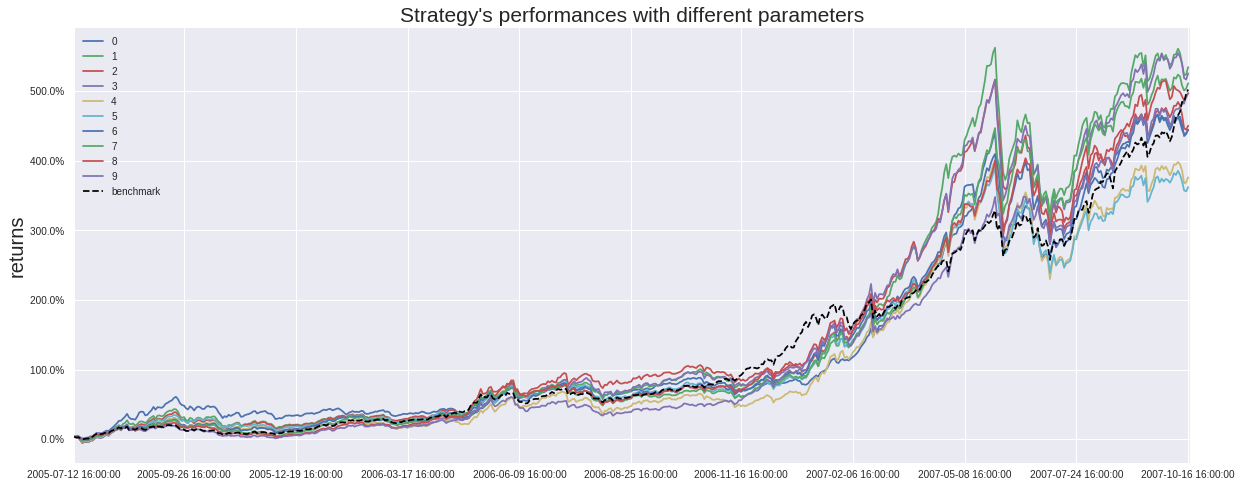

In [7]:
 # 回报率折线图    
pa.plot_returns()

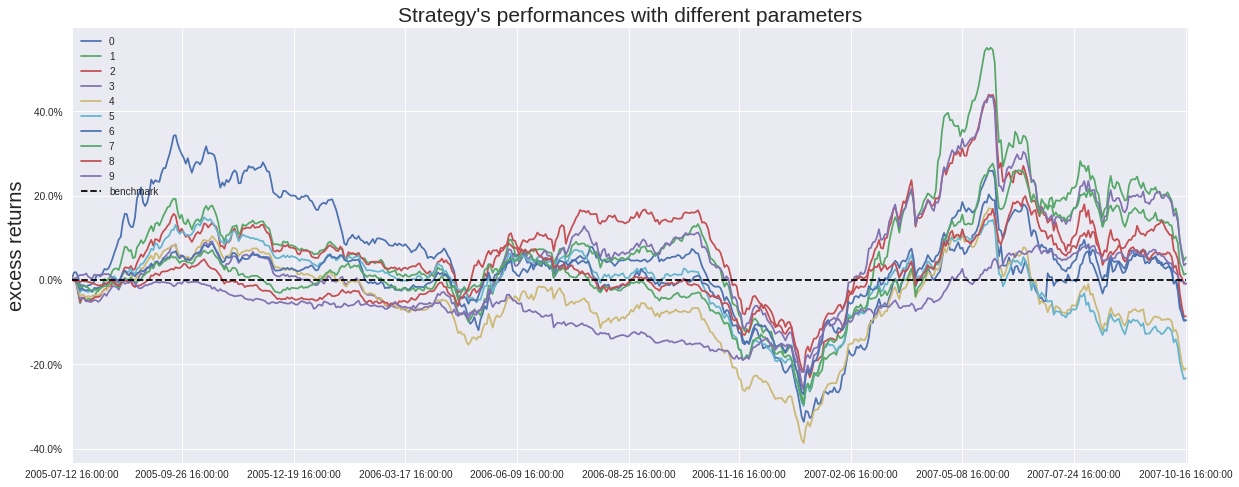

In [8]:
# 超额收益率图    
pa.plot_excess_returns()

## 熊市期间（2007-10-17 ~ 2008-11-04）

In [9]:
pa.get_backtest_data(file_name = 'results.pkl',
                          running_max = 10,
                          benchmark_id = None,
                          start_date = date[1],
                          end_date = date[2],
                          frequency = 'day',
                          initial_cash = '2000000',
                          param_names = ['quantile'],
                          param_values = [tuple(zip(range(0,100,10), range(10,101,10)))]
                          )

【已完成|运行中|待运行】: [0|0|10]. {'quantile': (0, 10)}
{'quantile': (10, 20)}
{'quantile': (20, 30)}
{'quantile': (30, 40)}
{'quantile': (40, 50)}
{'quantile': (50, 60)}
{'quantile': (60, 70)}
{'quantile': (70, 80)}
{'quantile': (80, 90)}
{'quantile': (90, 100)}
[0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [1|9|0]. [7|3|0]. [9|1|0]. 
【回测完成】总用时：66秒(即0.02小时)。


In [10]:
# 数据回测结果
pa.read_backtest_data('results.pkl')
# 回测结果
pa.evaluations_df

,quantile,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_position_days,avg_trade_return,benchmark_return,...,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,win_count,win_ratio
0,"(0, 10)",101,-0.5917373,0.4454081,0.02498965,-0.5788284,-0.7042787,105.0972,-0.07681874,-0.7169687,...,"[2008-01-15, 2008-11-04]",0,2008-11,0.3400343,-1.389351,-1.840138,259,0.04219178,111,0.3226744
1,"(10, 20)",101,-0.6047691,0.4908997,0.08253359,-0.5918123,-0.7042787,76.82051,-0.07729203,-0.7169687,...,"[2008-01-15, 2008-11-04]",0,2008-11,0.4214171,-1.28705,-1.709018,259,0.04219178,136,0.3333333
2,"(20, 30)",101,-0.6021624,0.5094989,0.1122236,-0.589214,-0.7042787,68.52294,-0.08522132,-0.7169687,...,"[2008-03-06, 2008-11-04]",0,2008-11,0.3850516,-1.234966,-1.675248,259,0.04219178,133,0.300905
3,"(30, 40)",101,-0.6277322,0.4967383,0.07562551,-0.6147277,-0.7042787,NaN,NaN,-0.7169687,...,"[2008-03-05, 2008-11-04]",0,2008-11,NaN,-1.318053,-1.820096,259,0.04219178,NaN,NaN
4,"(40, 50)",101,-0.6539179,0.5024465,0.07197858,-0.6409192,-0.7042787,61.25,-0.09400418,-0.7169687,...,"[2008-01-15, 2008-11-04]",0,2008-11,0.3297313,-1.355208,-1.86712,259,0.04219178,155,0.3195876
5,"(50, 60)",101,-0.658044,0.5085892,0.08400814,-0.6450523,-0.7042787,59.79518,-0.09603418,-0.7169687,...,"[2008-01-15, 2008-11-04]",0,2008-11,0.3495726,-1.346966,-1.842199,259,0.04219178,155,0.3222453
6,"(60, 70)",101,-0.6462814,0.4817367,0.06223173,-0.6332741,-0.7042787,68.17808,-0.09563859,-0.7169687,...,"[2008-01-15, 2008-11-04]",0,2008-11,0.3327941,-1.397598,-1.995966,259,0.04219178,142,0.3219955
7,"(70, 80)",101,-0.6494327,0.4890042,0.0821266,-0.6364282,-0.7042787,75.61421,-0.08853519,-0.7169687,...,"[2008-01-14, 2008-11-04]",0,2008-11,0.3442814,-1.383277,-1.991563,259,0.04219178,133,0.3189448
8,"(80, 90)",101,-0.693344,0.4706317,0.02224501,-0.6804861,-0.7042787,88.25,-0.1202558,-0.7169687,...,"[2008-01-15, 2008-11-04]",0,2008-11,0.2150037,-1.530892,-2.316829,259,0.04219178,103,0.2668394
9,"(90, 100)",101,-0.7013567,0.4326193,-0.0002021312,-0.6885483,-0.7042787,124.9672,-0.1574643,-0.7169687,...,"[2007-10-16, 2008-11-04]",0,2008-11,0.1290236,-1.68404,-2.791758,259,0.04219178,73,0.222561


如上表所示，小市值的股票表现要优于大市值的股表现。

并且随着市值的增长，策略的收益越来越小

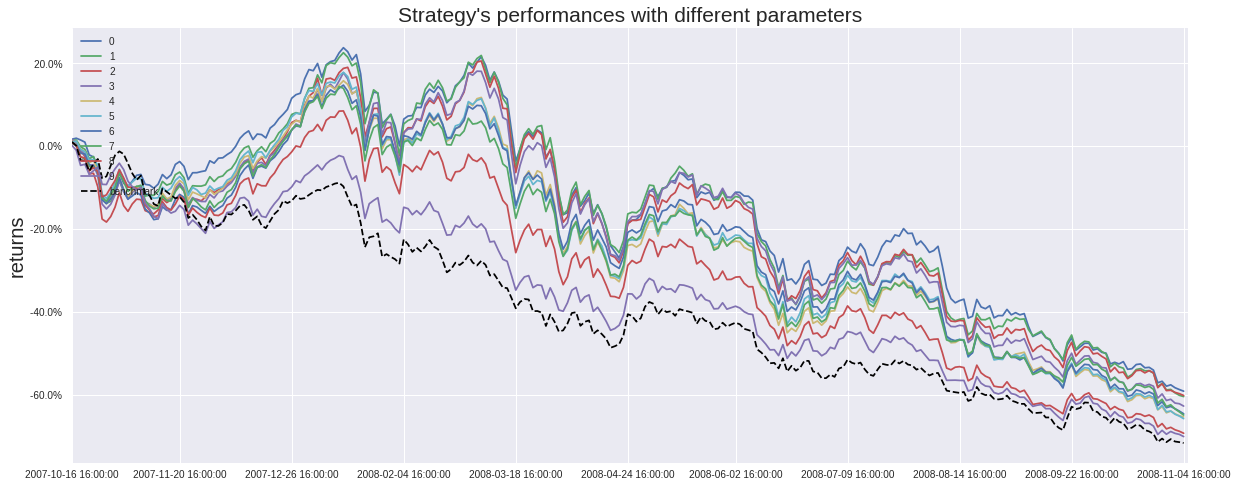

In [11]:
 # 回报率折线图    
pa.plot_returns()

## 牛市期间（2008-11-05 ~ 2009-08-04）

In [12]:
pa.get_backtest_data(file_name = 'results.pkl',
                          running_max = 10,
                          benchmark_id = None,
                          start_date = date[2],
                          end_date = date[3],
                          frequency = 'day',
                          initial_cash = '2000000',
                          param_names = ['quantile'],
                          param_values = [tuple(zip(range(0,100,10), range(10,101,10)))]
                          )

【已完成|运行中|待运行】: [0|0|10]. {'quantile': (0, 10)}
{'quantile': (10, 20)}
{'quantile': (20, 30)}
{'quantile': (30, 40)}
{'quantile': (40, 50)}
{'quantile': (50, 60)}
{'quantile': (60, 70)}
{'quantile': (70, 80)}
{'quantile': (80, 90)}
{'quantile': (90, 100)}
[0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [8|2|0]. 
【回测完成】总用时：52秒(即0.01小时)。


In [13]:
pa.read_backtest_data('results.pkl')
# 回测结果
pa.evaluations_df

,quantile,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_position_days,avg_trade_return,benchmark_return,...,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,win_count,win_ratio
0,"(0, 10)",101,2.787882,0.3290983,3.632282,5.048069,1.583534,81.47143,0.4603731,1.018545,...,"[2009-02-23, 2009-02-27]",0,2009-08,746.2301,15.21755,18.14326,185,0.02991781,285,0.9760274
1,"(10, 20)",101,1.988592,0.3834261,1.720942,3.390585,1.583534,62.33889,0.321438,1.018545,...,"[2009-02-23, 2009-02-27]",0,2009-08,44.77721,8.738543,10.17302,185,0.02991781,308,0.9305136
2,"(20, 30)",101,1.918556,0.389838,1.568478,3.252119,1.583534,56.85075,0.3068961,1.018545,...,"[2009-02-23, 2009-02-27]",0,2009-08,28.31519,8.239623,9.22292,185,0.02991781,298,0.8922156
3,"(30, 40)",101,1.937251,0.3875922,1.617614,3.288967,1.583534,52.56279,0.2604333,1.018545,...,"[2009-02-16, 2009-02-27]",0,2009-08,24.69642,8.382437,9.76392,185,0.02991781,320,0.8913649
4,"(40, 50)",101,1.53661,0.3921261,0.7950777,2.517944,1.583534,51.54338,0.2401835,1.018545,...,"[2009-02-23, 2009-02-27]",0,2009-08,20.51029,6.319252,7.540424,185,0.02991781,312,0.8739496
5,"(50, 60)",101,1.824291,0.3808971,1.375211,3.06759,1.583534,51.24887,0.2634176,1.018545,...,"[2009-02-23, 2009-02-27]",0,2009-08,20.42308,7.948578,9.554645,185,0.02991781,306,0.8668555
6,"(60, 70)",101,1.686863,0.3862787,1.090195,2.802432,1.583534,56.17327,0.2786478,1.018545,...,"[2009-02-23, 2009-02-27]",0,2009-08,20.23274,7.151397,8.38401,185,0.02991781,287,0.8776758
7,"(70, 80)",101,1.499324,0.3888733,0.6982805,2.448245,1.583534,62.66667,0.2465877,1.018545,...,"[2009-02-16, 2009-02-27]",0,2009-08,22.3508,6.192879,7.528301,185,0.02991781,283,0.8871473
8,"(80, 90)",101,1.629715,0.3684364,0.9856978,2.693552,1.583534,72.63871,0.2799105,1.018545,...,"[2009-02-23, 2009-02-27]",0,2009-08,29.88513,7.202197,9.069203,185,0.02991781,288,0.9
9,"(90, 100)",101,1.260507,0.3468413,0.3307706,2.010624,1.583534,101.6518,0.2706322,1.018545,...,"[2008-12-08, 2008-12-31]",0,2009-08,45.01996,5.681632,7.512017,185,0.02991781,255,0.9375


如上表所示，小市值的股票表现要优于大市值的股表现。

并且随着市值的增长，策略的收益越来越小

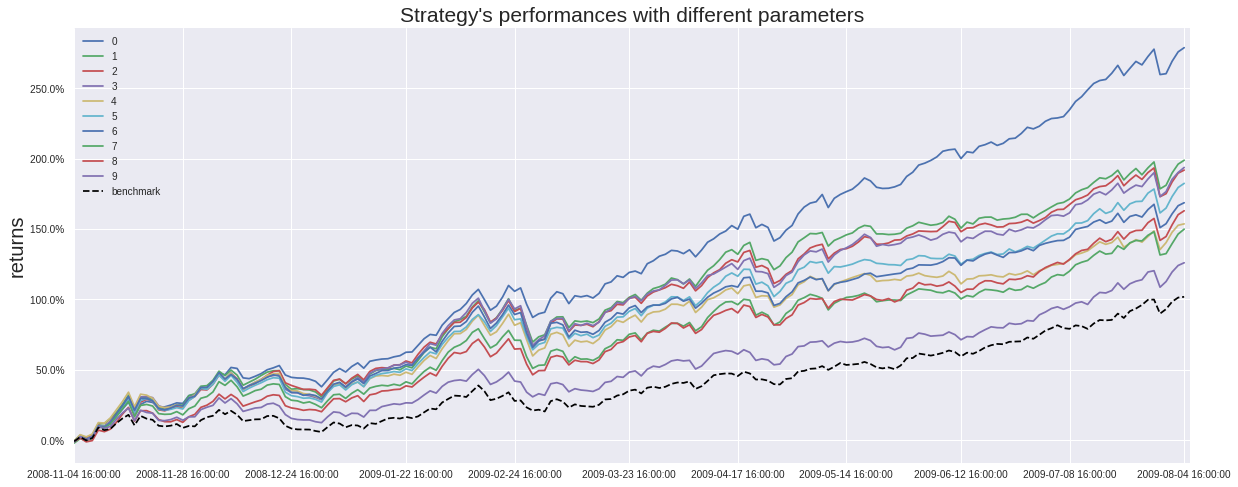

In [14]:
 # 回报率折线图    
pa.plot_returns()

## 熊市期间（2009-08-05 ~ 2013-06-27）

In [15]:
pa.get_backtest_data(file_name = 'results.pkl',
                          running_max = 10,
                          benchmark_id = None,
                          start_date = date[3],
                          end_date = date[4],
                          frequency = 'day',
                          initial_cash = '2000000',
                          param_names = ['quantile'],
                          param_values = [tuple(zip(range(0,100,10), range(10,101,10)))]
                          )

【已完成|运行中|待运行】: [0|0|10]. {'quantile': (0, 10)}
{'quantile': (10, 20)}
{'quantile': (20, 30)}
{'quantile': (30, 40)}
{'quantile': (40, 50)}
{'quantile': (50, 60)}
{'quantile': (60, 70)}
{'quantile': (70, 80)}
{'quantile': (80, 90)}
{'quantile': (90, 100)}
[0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [0|10|0]. [1|9|0]. [3|7|0]. [4|6|0]. [5|5|0]. [6|4|0]. [6|4|0]. [6|4|0]. [7|3|0]. [8|2|0]. [8|2|0]. [8|2|0]. [8|2|0]. [8|2|0]. 
【回测完成】总用时：210秒(即0.06小时)。


In [16]:
pa.read_backtest_data('results.pkl')
# 回测结果
pa.evaluations_df

,quantile,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_position_days,avg_trade_return,benchmark_return,...,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,win_count,win_ratio
0,"(0, 10)",101,0.3605628,0.2482973,0.2249012,0.08505142,-0.1412023,NaN,NaN,-0.436834,...,"[2011-04-18, 2012-01-05]",0,2013-06,NaN,0.1814414,0.2360159,943,0.1559452,NaN,NaN
1,"(10, 20)",101,0.108691,0.2614017,0.180066,0.02773177,-0.1412023,NaN,NaN,-0.436834,...,"[2011-04-18, 2012-12-03]",0,2013-06,NaN,-0.04693249,-0.0622704,943,0.1559452,NaN,NaN
2,"(20, 30)",101,-0.002615381,0.2667831,0.1576018,-0.0006940346,-0.1412023,144.7817,0.02711199,-0.436834,...,"[2011-04-21, 2012-12-03]",0,2013-06,1.136205,-0.152536,-0.2018402,943,0.1559452,886,0.4886928
3,"(30, 40)",101,-0.119729,0.2716952,0.1299104,-0.03324333,-0.1412023,NaN,NaN,-0.436834,...,"[2011-03-28, 2012-12-03]",0,2013-06,NaN,-0.2695791,-0.3602595,943,0.1559452,NaN,NaN
4,"(40, 50)",101,-0.2721168,0.2713055,0.08522371,-0.08075562,-0.1412023,NaN,NaN,-0.436834,...,"[2010-11-10, 2012-12-03]",0,2013-06,NaN,-0.445091,-0.6025126,943,0.1559452,NaN,NaN
5,"(50, 60)",101,-0.2847637,0.269764,0.08139707,-0.08501721,-0.1412023,158.8822,0.01080682,-0.436834,...,"[2010-11-10, 2012-12-03]",0,2013-06,0.893645,-0.4634318,-0.6404554,943,0.1559452,855,0.4672131
6,"(60, 70)",101,-0.1825373,0.2689073,0.1157708,-0.05203072,-0.1412023,NaN,NaN,-0.436834,...,"[2010-11-10, 2012-12-03]",0,2013-06,NaN,-0.3422395,-0.4756103,943,0.1559452,NaN,NaN
7,"(70, 80)",101,-0.4259698,0.2581171,0.0265372,-0.1368409,-0.1412023,NaN,NaN,-0.436834,...,"[2010-01-19, 2012-12-03]",0,2013-06,NaN,-0.6851189,-0.9629781,943,0.1559452,NaN,NaN
8,"(80, 90)",101,-0.4279675,0.2467576,0.02177613,-0.1376383,-0.1412023,NaN,NaN,-0.436834,...,"[2010-11-08, 2012-12-03]",0,2013-06,NaN,-0.7198898,-1.047003,943,0.1559452,NaN,NaN
9,"(90, 100)",101,-0.4373273,0.2332054,0.01516355,-0.1414018,-0.1412023,NaN,NaN,-0.436834,...,"[2009-08-04, 2013-06-27]",0,2013-06,NaN,-0.7778627,-1.153109,943,0.1559452,NaN,NaN


如上表所示，小市值的股票表现要优于大市值的股表现。

只有第一个和第二个十分位的股票是产生了正收益的。

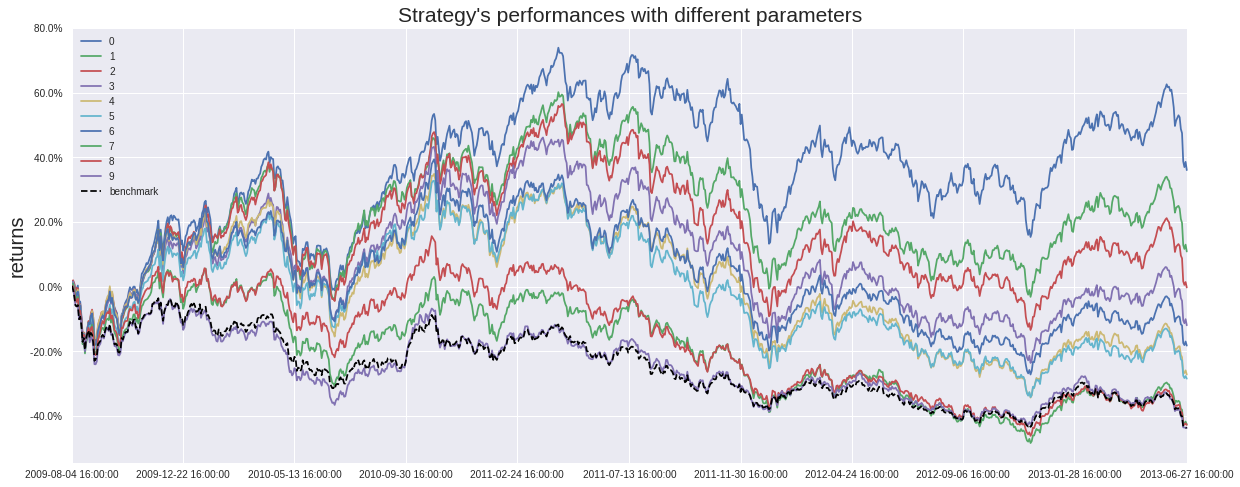

In [17]:
 # 回报率折线图    
pa.plot_returns()

由上面结果可以看出，小市值的股票在牛市和熊市中的表现均高于大市值股票。

并且策略的收益率与股票所在分位之间存在一定趋势：即分为越小，市值越小的股票，表现越好。

这说明流通市值这一指标的分层效果良好。

因此可得出结论：
1. 流通市值可以作为一个有效因子进行选股
2. 不管在牛市还是熊市，都是流通市值越小，表现越好
